### Sub-sampling 

When running Metropolis-Hastings, there are ways to reduce the error to the stationary distribution and the autocorrelation of the samples. These are issues for the following reasons: 

1. Reducing your error means a better estimate of the stationary distribution. 
2. Autocorrelation is a measure of correlation with a delayed copied with itself. In other words, how correlated are the samples? Ideally, we want the samples as uncorrelated with each other as much as possible so that the samples are more likely to be more representative of the stationary distribution.

To reduce both of these, we can utilize *subsampling*, where we take a subset of the samples, will be taken every $k$ steps. We've utilized a subsampling version in VoteKit to study: 

1. How well subsampling does compared to continuous sampling (taking all the samples) and the pre-calculated PMF.
2. How long your chain length should be for certain thresholds for the error to the stationary distribution. 

First, we're going to import some libraries and create some helper functions for these diagnostics. 

In [7]:
import sys
import os

# Add the repo root to sys.path
repo_path = os.path.abspath(os.path.join(os.getcwd(), '../..'))  # adjust as needed
if repo_path not in sys.path:
    sys.path.insert(0, repo_path)

from src.votekit.ballot_generator import name_BradleyTerry 
from src.votekit.pref_interval import PreferenceInterval
from src.votekit.pref_profile import PreferenceProfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import math

# Helper functions

def generate_BT_args(n_cands, alpha=1):
    '''
        generates arguments for name_BradleyTerry with n_cands,
        generates single slate and single bloc, 
    '''
    # num cands goes up to 26
    cands = [chr(ord('a')+i) for i in range(n_cands)]
    bloc_name = "H"
    pref_interval = PreferenceInterval.from_dirichlet(candidates=cands, alpha=alpha)
    pref_intervals_by_bloc = {
        bloc_name: {
            bloc_name : pref_interval
        }
    }
    bloc_voter_prop = {bloc_name: 1}
    cohesion_paramteters = {
        bloc_name: {
            bloc_name: 1
        }
    }
    
    return {
        "candidates": cands,
        "pref_intervals_by_bloc": pref_intervals_by_bloc,
        "bloc_voter_prop" : bloc_voter_prop,
        "cohesion_parameters": cohesion_paramteters
    }

def total_variation_distance(P, Q, labels):
    sum = 0 
    for x in labels:
        sum += abs(P[x] - Q[x])
    return (1/2)*sum

Next, let's initialize some parameters for our experiment: 

In [3]:
# Initialize a version of BT w/ 5 candidates 
n_cands = 5
bt = name_BradleyTerry(**generate_BT_args(n_cands=n_cands, alpha=1))

# Get the precomputed PMF
new_ranking = {}
for key in bt.pdfs_by_bloc['H'].keys():
    new_ranking[''.join(key)] = bt.pdfs_by_bloc['H'][key]

# Initialize interested parameters --- size of chain and size of ensemble 
num_ballots_arr = [int(10e1), int(10e2), int(10e3), int(10e4), int(10e5), int(10e6)]
size_of_ensembles = [100, 1000, 10000]

# Print graphs of the PDFs?
verbose = False  

  0%|                                                     | 0/6 [00:00<?, ?it/s]

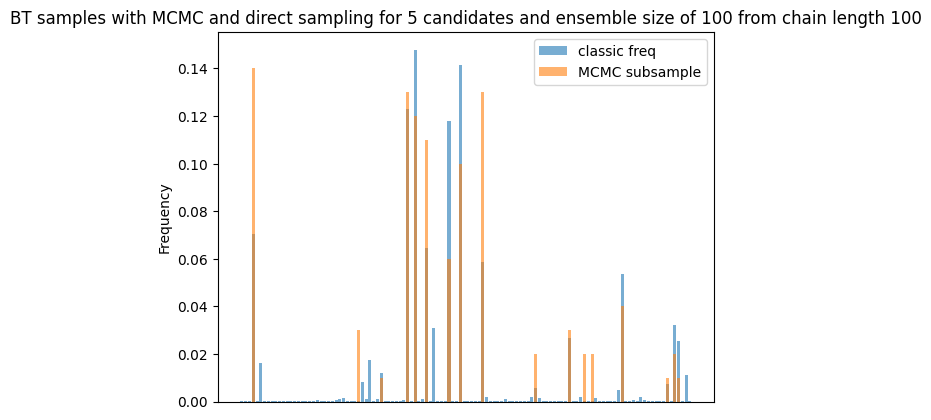

The TV for chain length 100 and subsample size 100 is 0.282978.


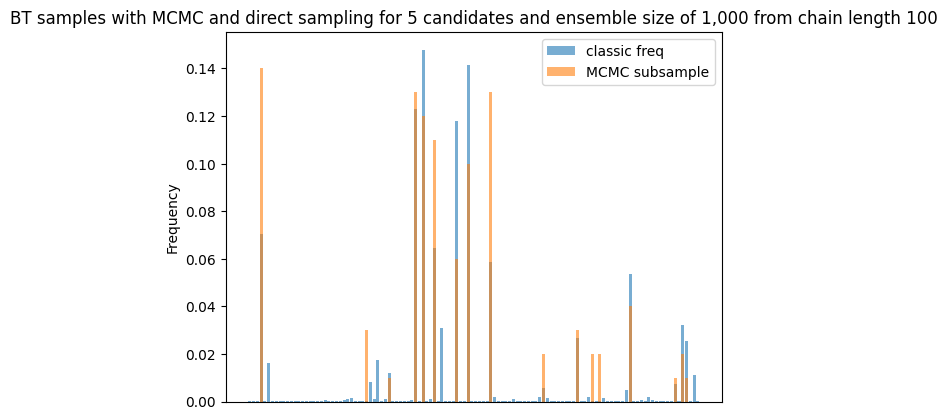

The TV for chain length 100 and subsample size 1000 is 0.282978.


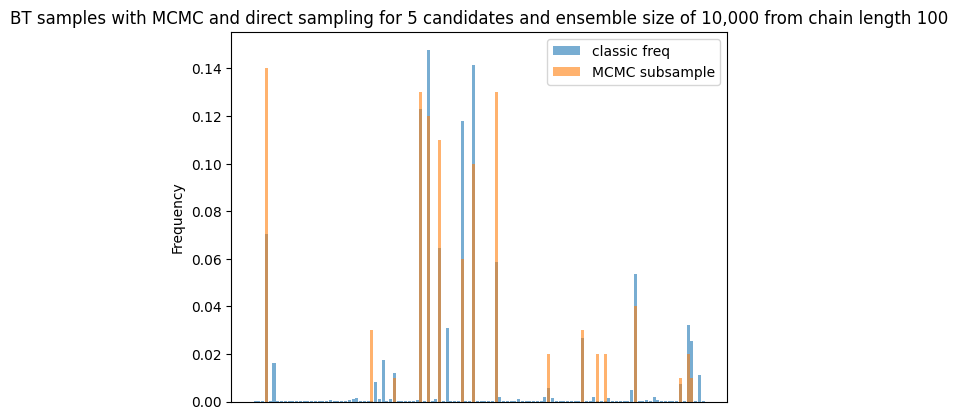

 17%|███████▌                                     | 1/6 [00:00<00:03,  1.35it/s]

The TV for chain length 100 and subsample size 10000 is 0.282978.


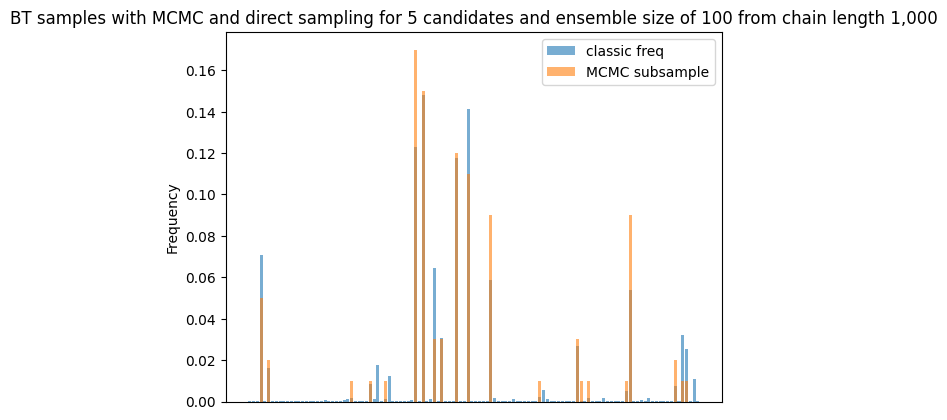

The TV for chain length 1000 and subsample size 100 is 0.188902.


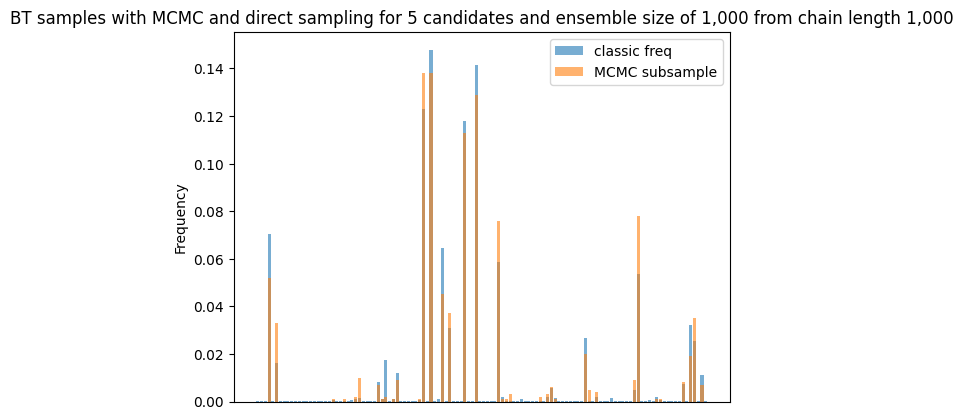

The TV for chain length 1000 and subsample size 1000 is 0.119123.


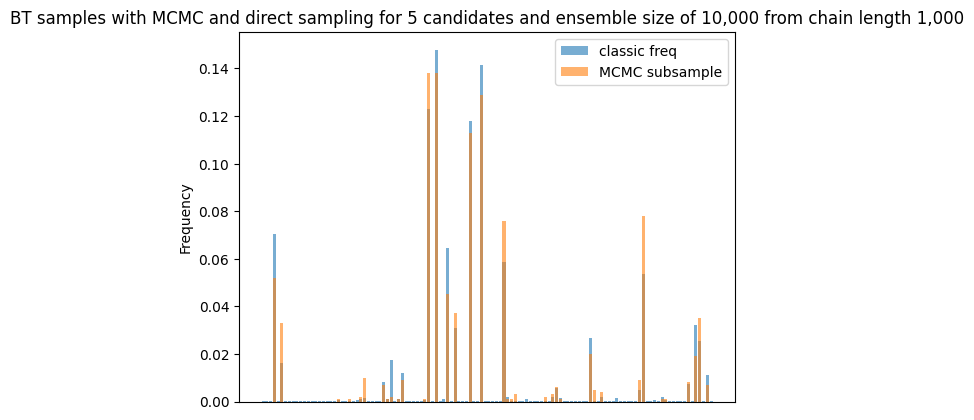

 33%|███████████████                              | 2/6 [00:01<00:02,  1.35it/s]

The TV for chain length 1000 and subsample size 10000 is 0.119123.


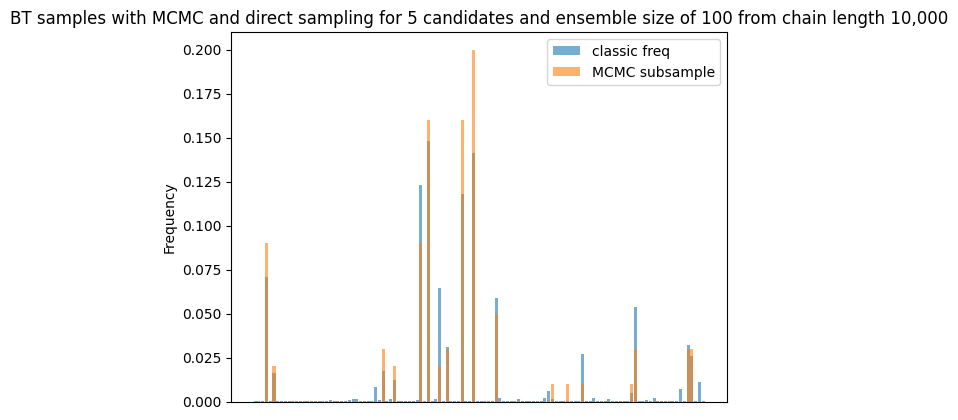

The TV for chain length 10000 and subsample size 100 is 0.184359.


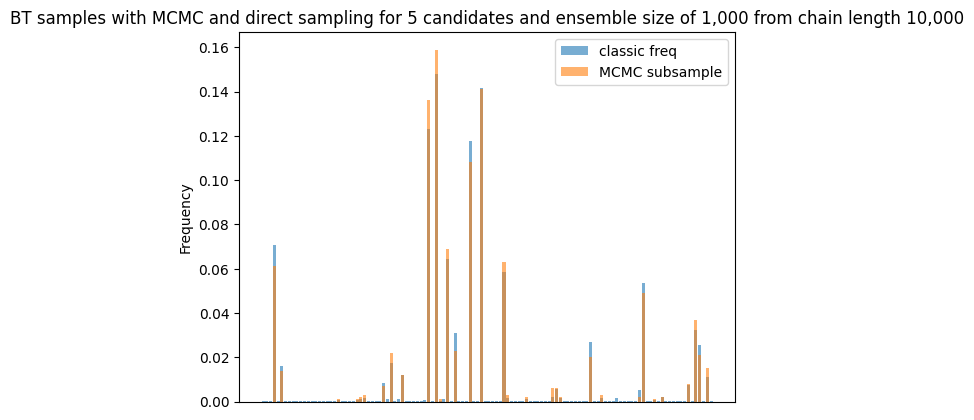

The TV for chain length 10000 and subsample size 1000 is 0.059089.


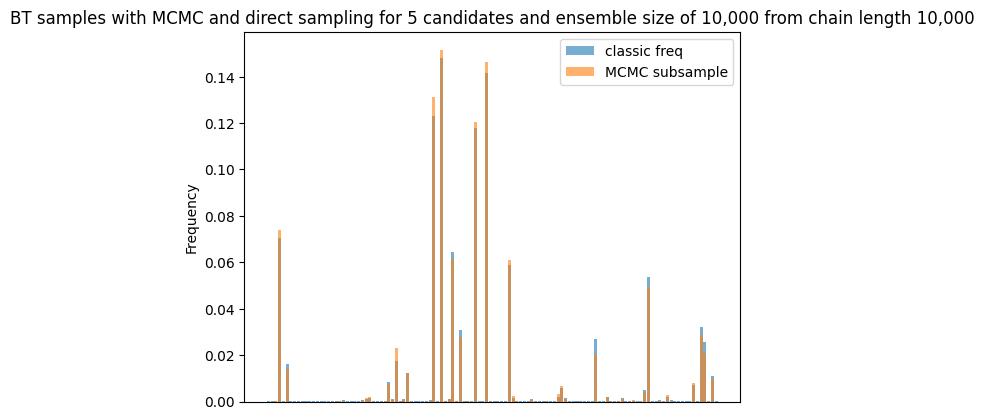

 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.16it/s]

The TV for chain length 10000 and subsample size 10000 is 0.037397.


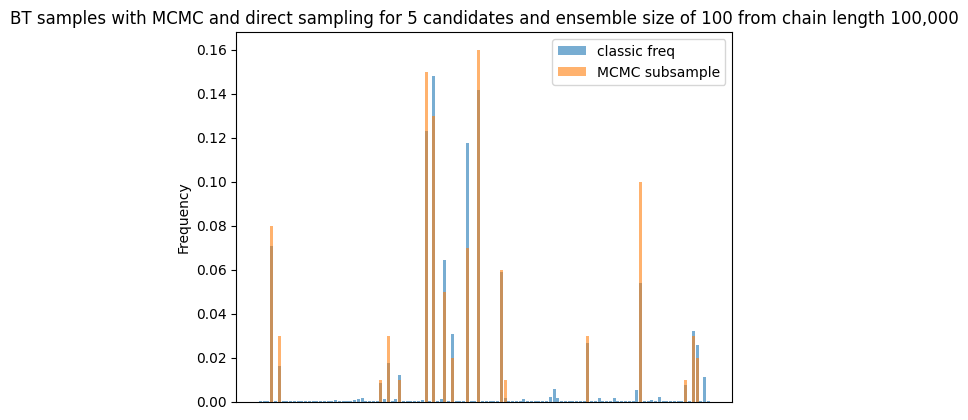

The TV for chain length 100000 and subsample size 100 is 0.145009.


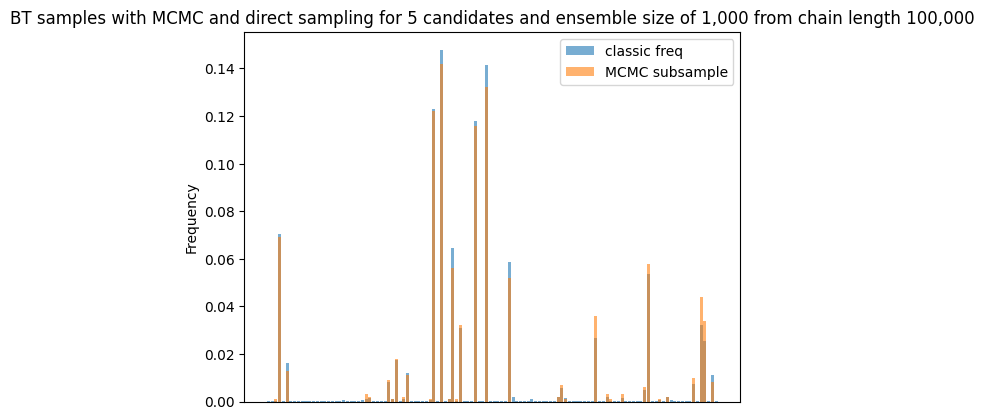

The TV for chain length 100000 and subsample size 1000 is 0.050053.


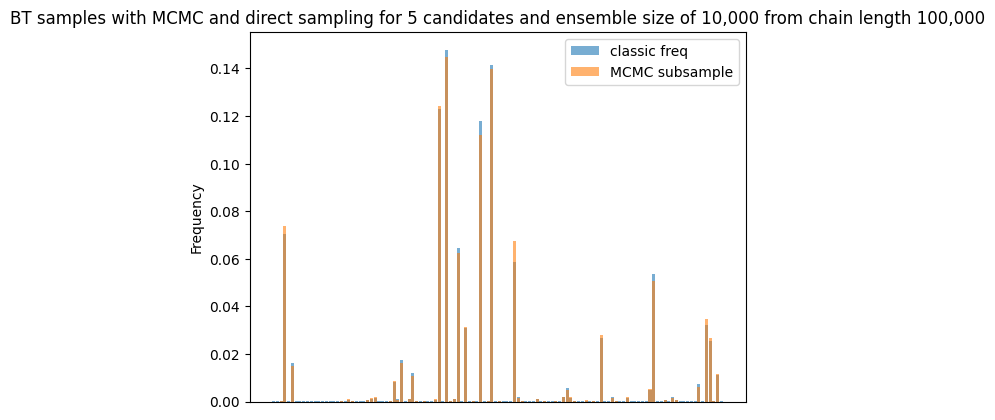

 67%|██████████████████████████████               | 4/6 [00:05<00:03,  1.53s/it]

The TV for chain length 100000 and subsample size 10000 is 0.023687.


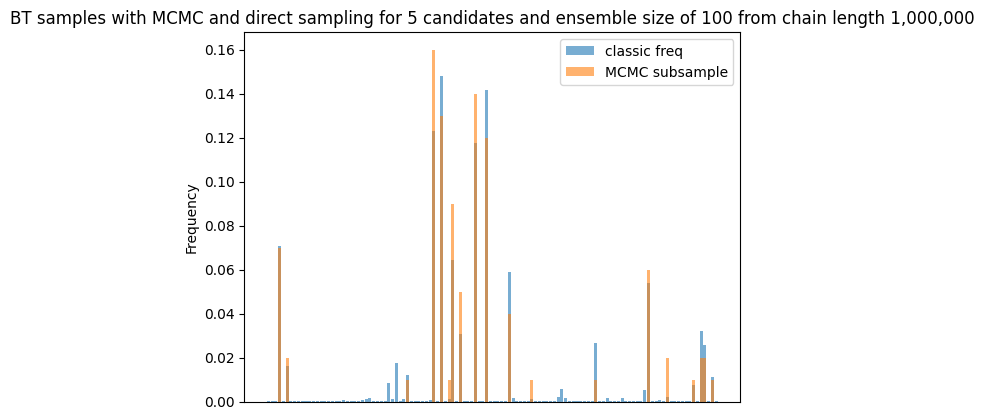

The TV for chain length 1000000 and subsample size 100 is 0.152807.


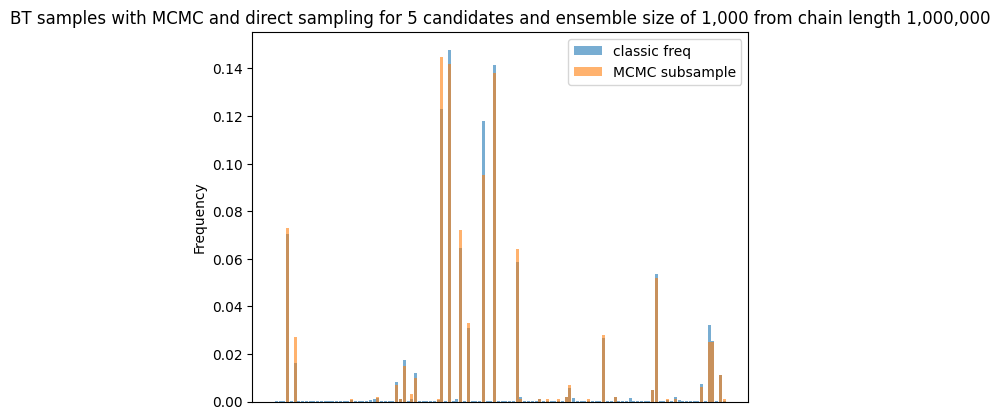

The TV for chain length 1000000 and subsample size 1000 is 0.059418.


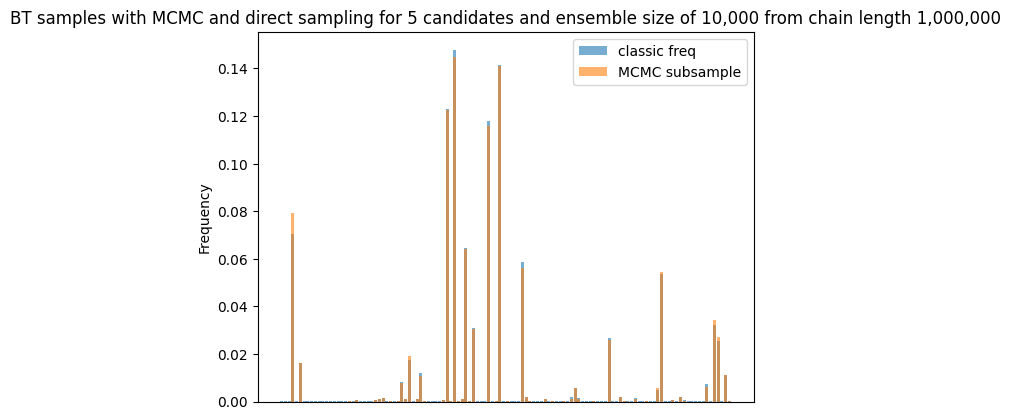

 83%|█████████████████████████████████████▌       | 5/6 [00:25<00:08,  8.36s/it]

The TV for chain length 1000000 and subsample size 10000 is 0.016747.


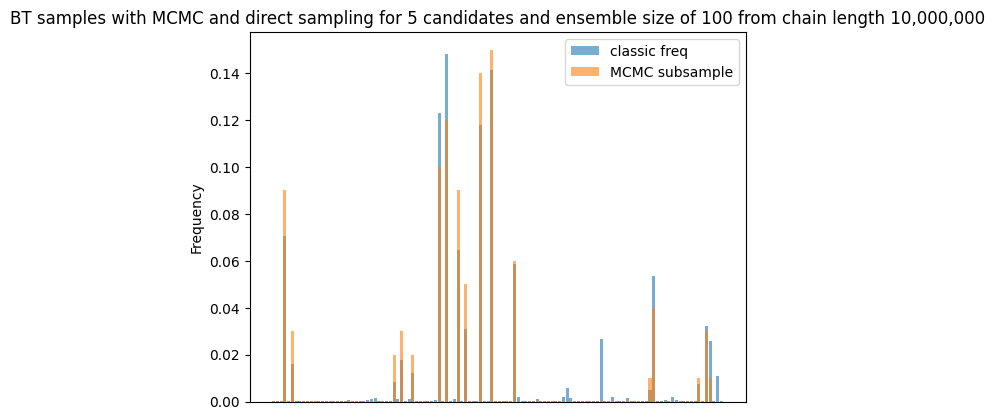

The TV for chain length 10000000 and subsample size 100 is 0.150163.


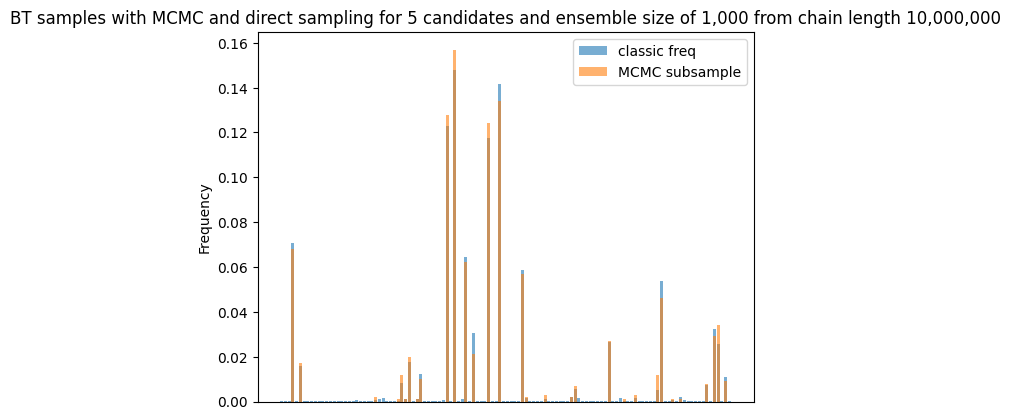

The TV for chain length 10000000 and subsample size 1000 is 0.052068.


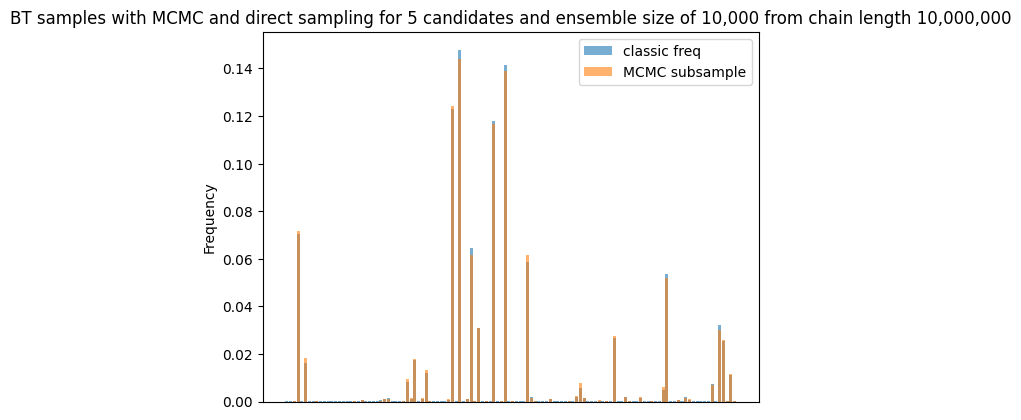

100%|█████████████████████████████████████████████| 6/6 [06:45<00:00, 67.62s/it]

The TV for chain length 10000000 and subsample size 10000 is 0.018387.


In [5]:
results = np.zeros((len(num_ballots_arr), len(size_of_ensembles)))
for k in tqdm(range(len(num_ballots_arr))):
    bals_BT_MCMC_all_samples_ballots = bt.generate_profile_MCMC_arr_ballots(num_ballots_arr[k])
    for j in range(len(size_of_ensembles)):
        # Subsample 
        bals_BT_MCMC_subsample_ballots = [bals_BT_MCMC_all_samples_ballots[i*num_ballots_arr[k]//size_of_ensembles[j] + num_ballots_arr[k]//(2*size_of_ensembles[j])] for i in range(size_of_ensembles[j])]

        # Convert back to PreferenceProfile object 
        bals_BT_MCMC_subsample = PreferenceProfile(ballots=bals_BT_MCMC_subsample_ballots).group_ballots()

        # Transform subsample so labels are well defined 
        ballot_rankings_MCMC_subsample = [bal.ranking for bal in bals_BT_MCMC_subsample.ballots]
        bal_labels_MCMC_subsample = ["".join([list(cand)[0] for cand in ranking]) for ranking in ballot_rankings_MCMC_subsample]
        bal_weights_MCMC_subsample = [int(bal.weight) for bal in bals_BT_MCMC_subsample.ballots]

        bal_rankings_map_MCMC_subsample = {bal_labels_MCMC_subsample[i]: bal_weights_MCMC_subsample[i]/size_of_ensembles[j] for i in range(len(ballot_rankings_MCMC_subsample))}
        
        x_labels = list(new_ranking.keys())
        # TODO: Some redundancy here, simplify
        all_keys = [list(m.keys()) for m in [
            new_ranking, bal_rankings_map_MCMC_subsample
        ]]
        flattened_keys = [k for sublist in all_keys for k in sublist]
        
        for key in flattened_keys:
            new_ranking.setdefault(key, 0) 
            bal_rankings_map_MCMC_subsample.setdefault(key, 0)
        
        all_keys = list(set(new_ranking) | set(bal_rankings_map_MCMC_subsample))

        results[k][j] = total_variation_distance(new_ranking, bal_rankings_map_MCMC_subsample, all_keys)

        if verbose: 
            plt.bar(all_keys, [new_ranking[k] for k in all_keys], label="classic freq", alpha=0.6)
            plt.bar(all_keys, [bal_rankings_map_MCMC_subsample[k] for k in all_keys], label="MCMC subsample", alpha=0.6)
            # plt.xticks(rotation=45, ha='right', fontsize=6)
            plt.xticks([]) # Hide the x labels if there are too many candidates to display
            plt.legend()
            plt.ylabel("Frequency")
            plt.title(f"BT samples with MCMC and direct sampling for {n_cands} candidates and ensemble size of {size_of_ensembles[j]:,} from chain length {num_ballots_arr[k]:,}")
            plt.show()
            print(f'The TV for chain length {num_ballots_arr[k]} and subsample size {size_of_ensembles[j]} is {results[k][j]:2f}.')

Now, let's look at the plots that summarize these results

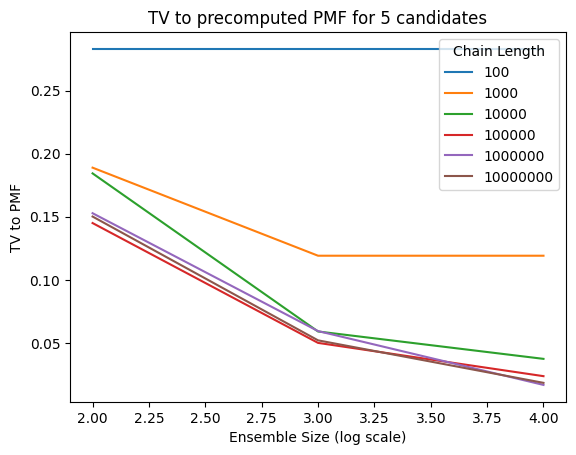

In [8]:
for i in range(len(num_ballots_arr)):
    plt.plot([math.log10(j) for j in size_of_ensembles], results[i][::], label = f'{num_ballots_arr[i]}')
plt.xlabel('Ensemble Size (log scale)')
plt.ylabel(f'TV to PMF')
plt.title(f'TV to precomputed PMF for {n_cands} candidates')
legend = plt.legend()
legend.set_title('Chain Length')
plt.show()

Now, what are these plots trying to say? 

1. In the case the chain length is 100, 1000, 10000, there are cases where the ensemble size equals the chain length or exceeds it. In the case where it equals, this is continuous sampling. Notice how the error is higher than the other chain lengths where there are subsampling. This means that to reduce error for Bradley-Terry, it's a generally a good idea to use subsampling rather than continuous sampling. However, if the continuous sample size is large enough, the error difference is neglible. In the case where it exceeds it, the sample resorts to the chain length — for example, on the plot where it reads a chain length of 100 but ensemble size 1000, the ensemble size is 100. 
2. Subsampling enjoys a decrease in error for a bigger chain length (and hence a larger spacing between samples). However, it seems that the improvements aren't that noticeable for larger sample sizes. Note that for 10,000,000 it takes a while to generate the chain lengths, so there's a huge trade off in terms of computational run-time.

The moral here is that some implementation of subsampling is good to reduce error but a larger chain length is not necessarily good, especially with regards to how long it takes to generate these samples. 

Now, let's see if these plots change if we change from 5 to 6 candidates

In [9]:
# Initialize a version of BT w/ 5 candidates 
n_cands = 6
bt = name_BradleyTerry(**generate_BT_args(n_cands=n_cands, alpha=1))

# Get the precomputed PMF
new_ranking = {}
for key in bt.pdfs_by_bloc['H'].keys():
    new_ranking[''.join(key)] = bt.pdfs_by_bloc['H'][key]

verbose = False  

  0%|                                                     | 0/6 [00:00<?, ?it/s]

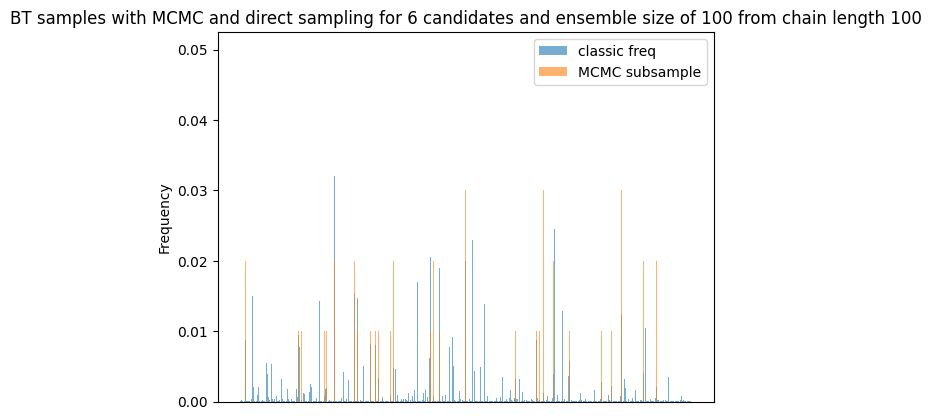

The TV for chain length 100 and subsample size 100 is 0.697979.


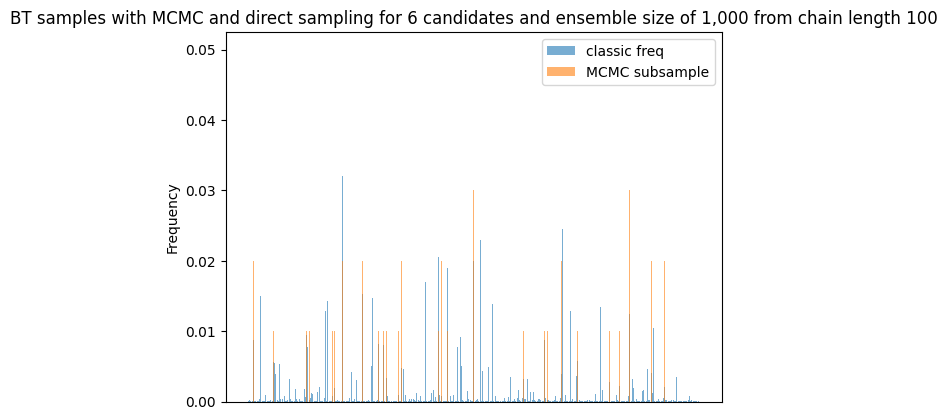

The TV for chain length 100 and subsample size 1000 is 0.697979.


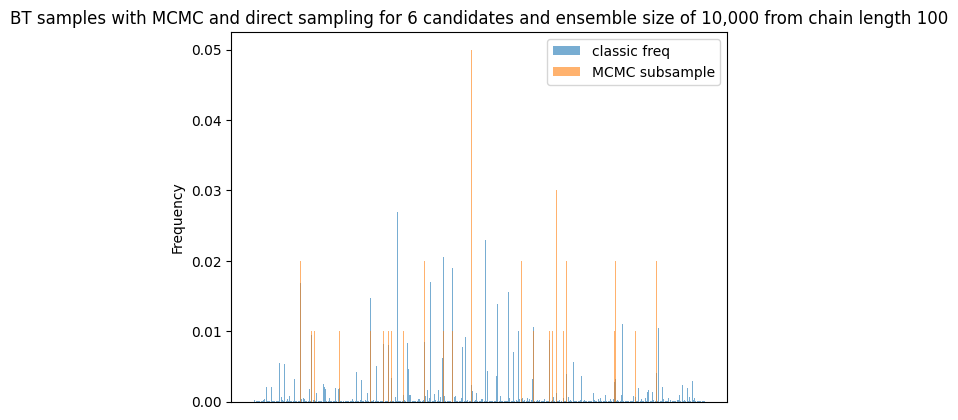

 17%|███████▌                                     | 1/6 [00:13<01:08, 13.61s/it]

The TV for chain length 100 and subsample size 10000 is 0.697979.


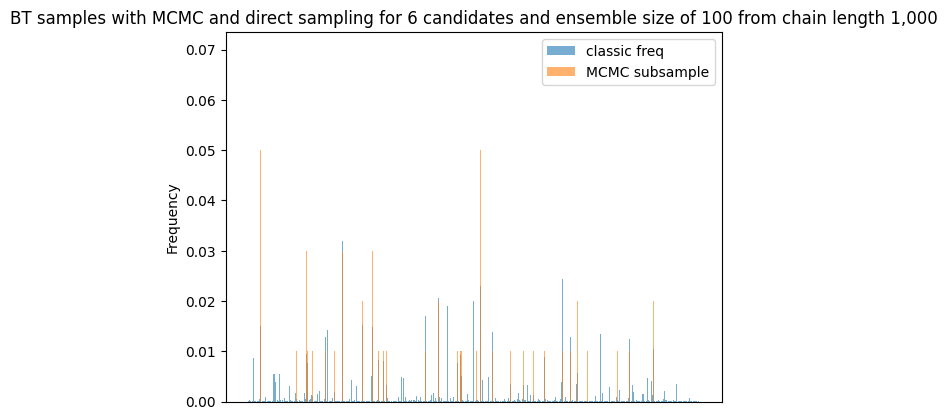

The TV for chain length 1000 and subsample size 100 is 0.489177.


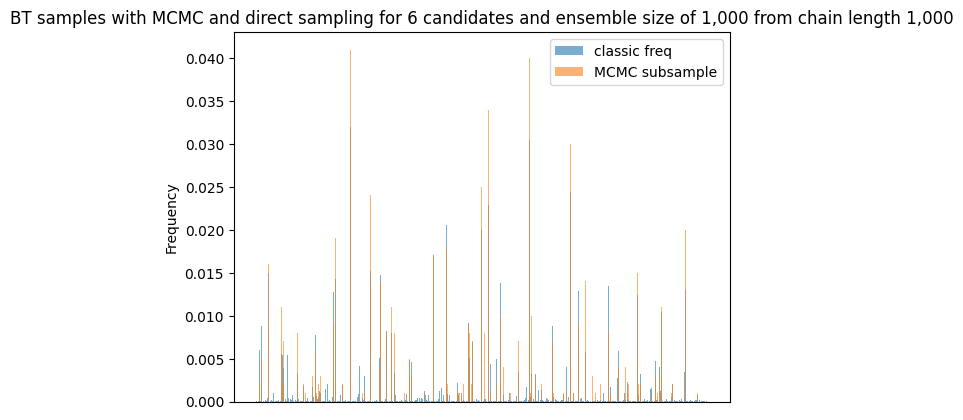

The TV for chain length 1000 and subsample size 1000 is 0.264398.


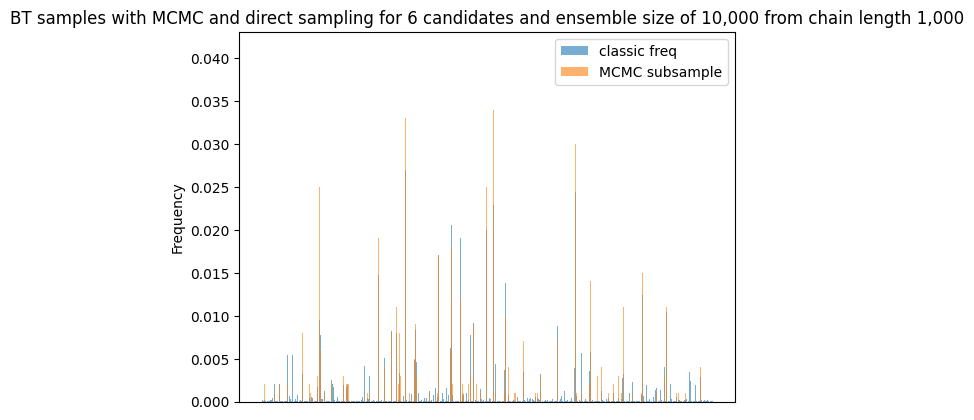

 33%|███████████████                              | 2/6 [00:16<00:29,  7.30s/it]

The TV for chain length 1000 and subsample size 10000 is 0.264398.


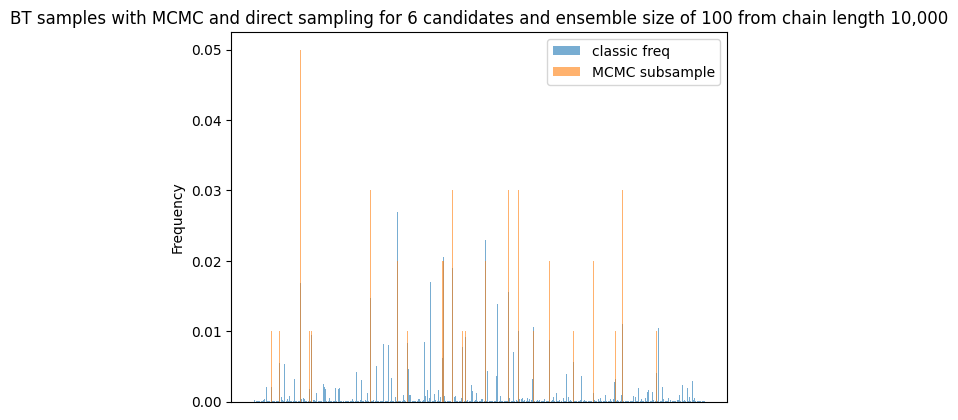

The TV for chain length 10000 and subsample size 100 is 0.482838.


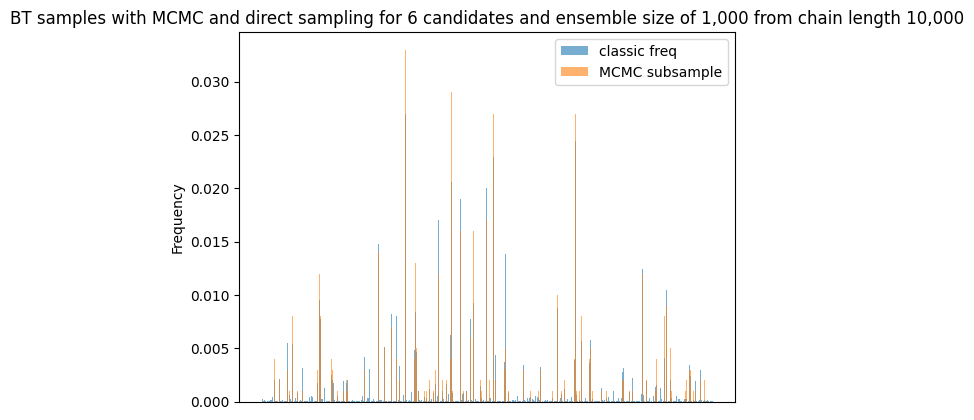

The TV for chain length 10000 and subsample size 1000 is 0.178784.


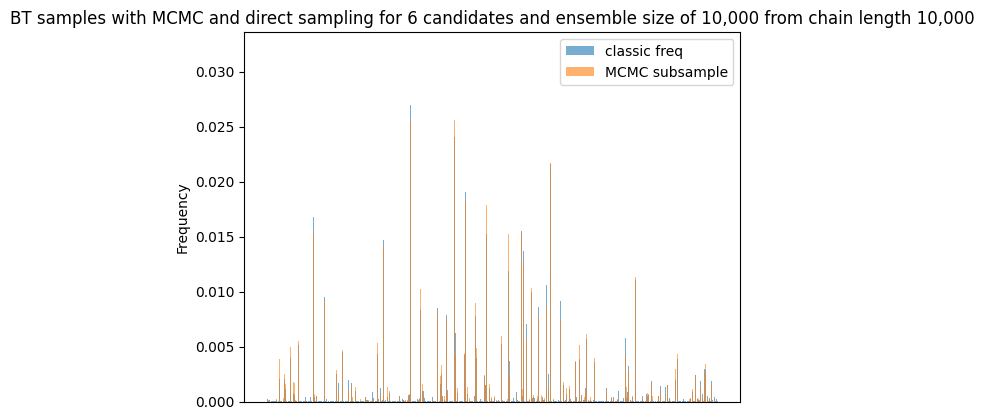

 50%|██████████████████████▌                      | 3/6 [00:19<00:15,  5.32s/it]

The TV for chain length 10000 and subsample size 10000 is 0.091519.


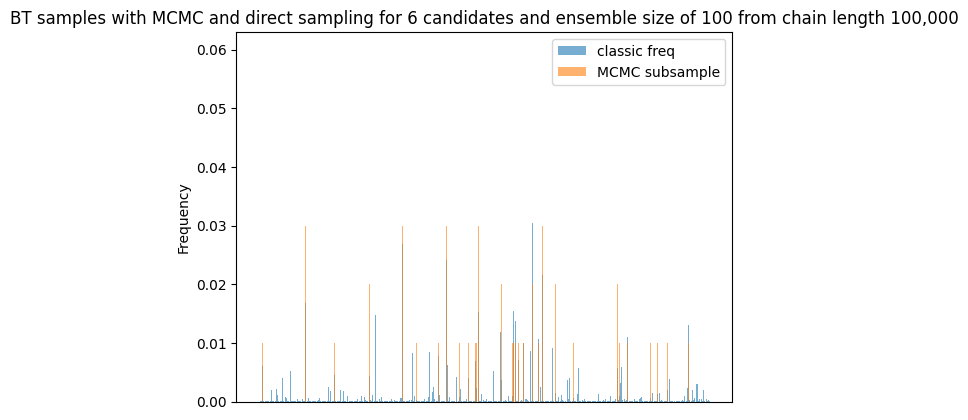

The TV for chain length 100000 and subsample size 100 is 0.449735.


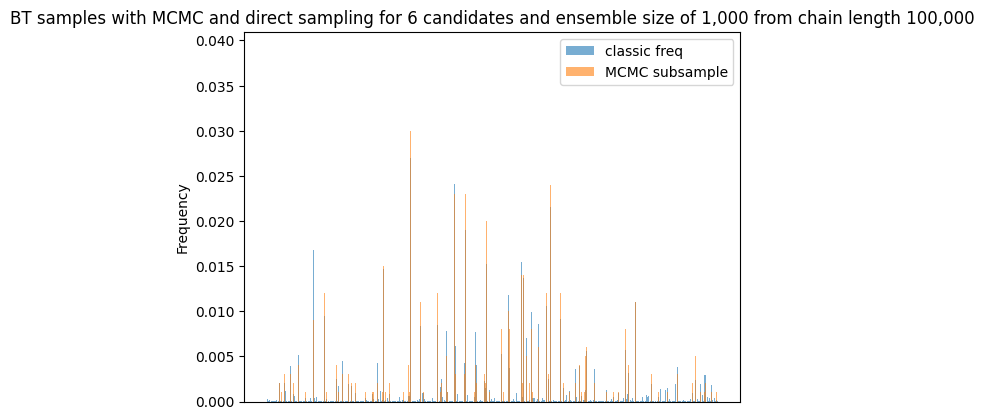

The TV for chain length 100000 and subsample size 1000 is 0.177755.


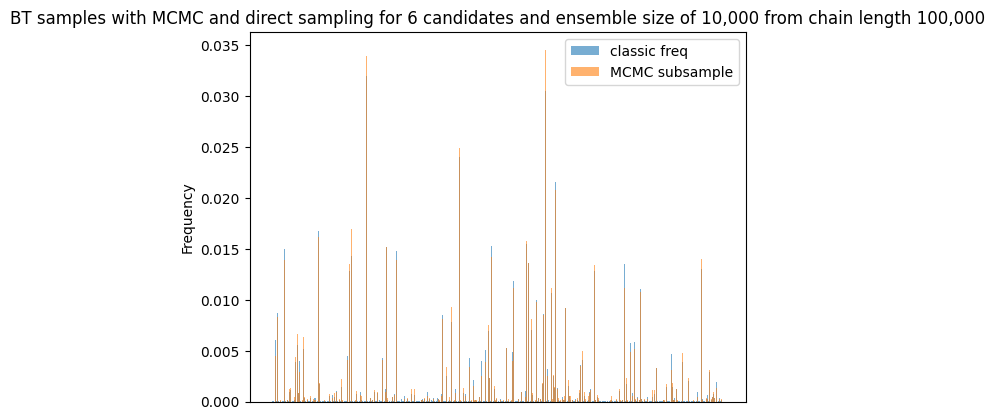

 67%|██████████████████████████████               | 4/6 [00:23<00:09,  4.78s/it]

The TV for chain length 100000 and subsample size 10000 is 0.061179.


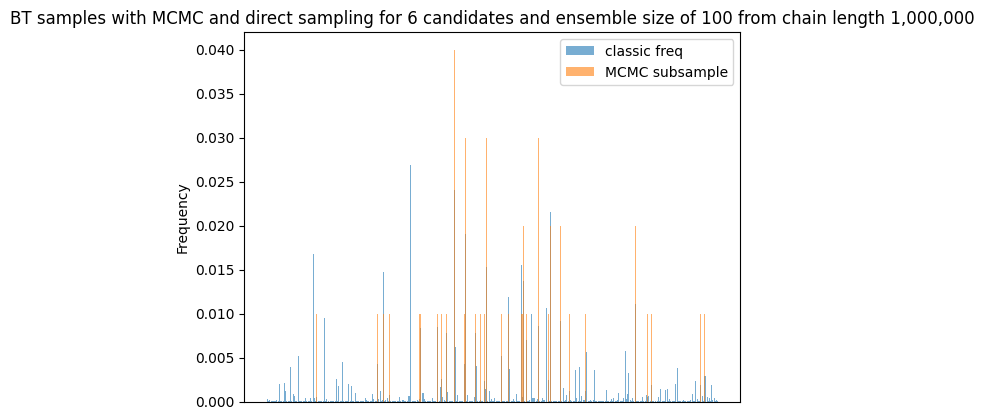

The TV for chain length 1000000 and subsample size 100 is 0.480502.


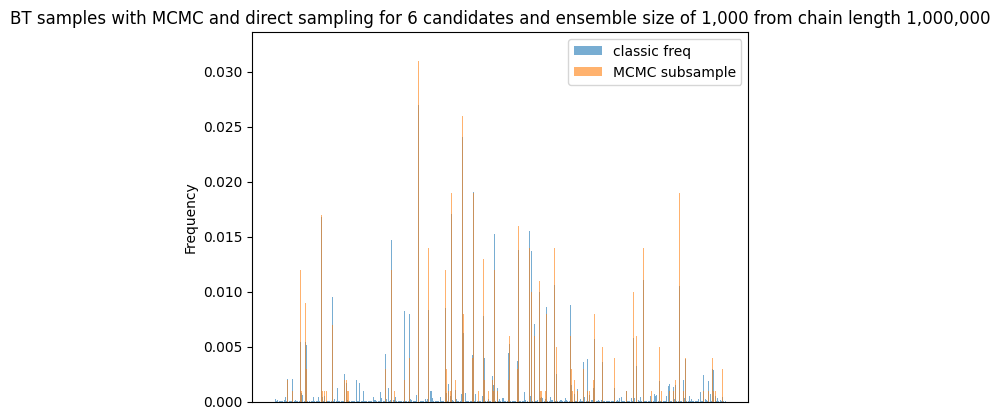

The TV for chain length 1000000 and subsample size 1000 is 0.188010.


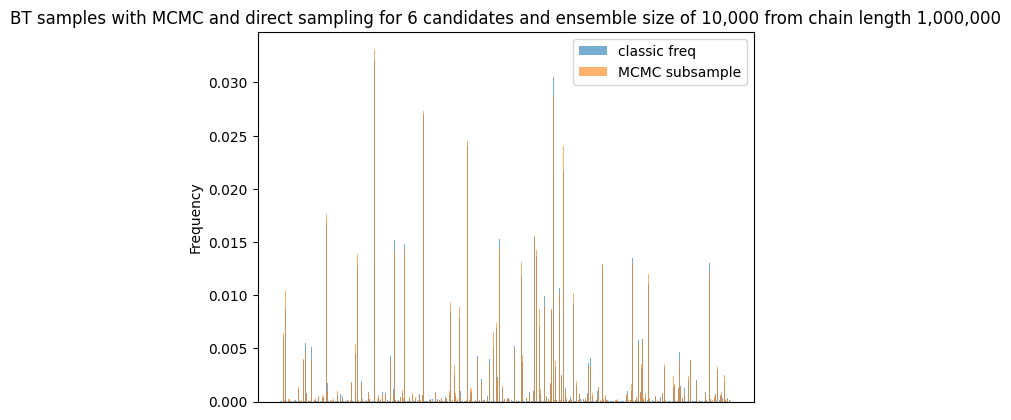

 83%|█████████████████████████████████████▌       | 5/6 [00:39<00:08,  8.72s/it]

The TV for chain length 1000000 and subsample size 10000 is 0.058630.


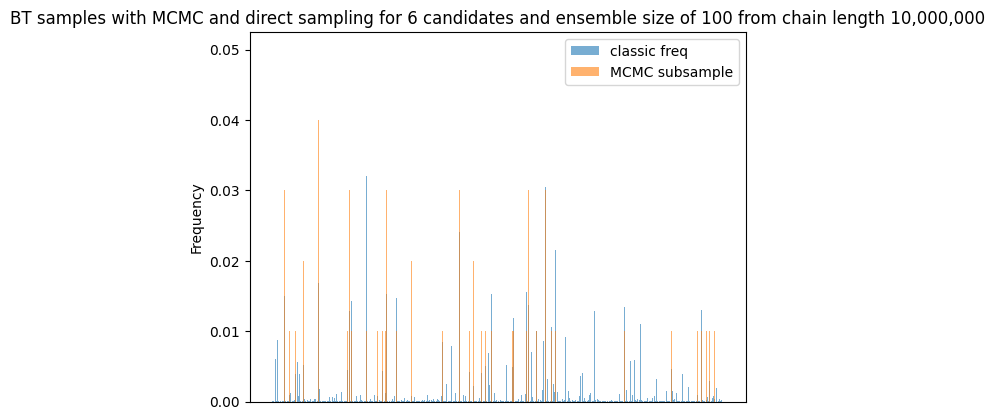

The TV for chain length 10000000 and subsample size 100 is 0.461928.


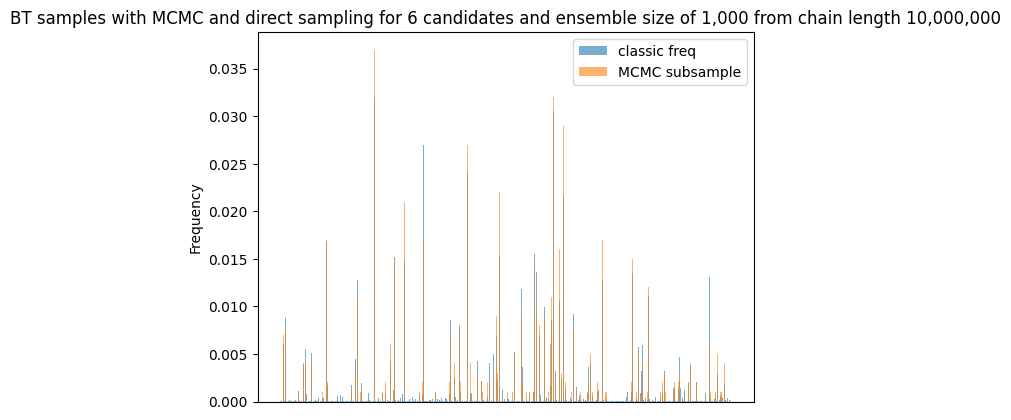

The TV for chain length 10000000 and subsample size 1000 is 0.166455.


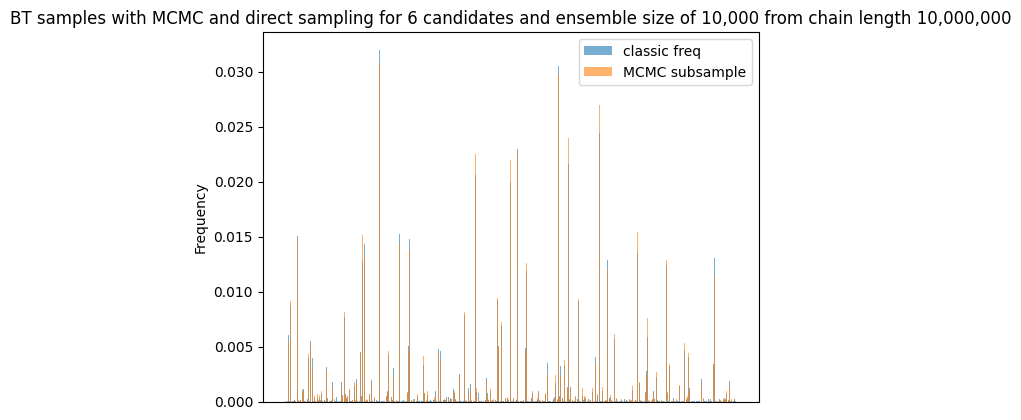

100%|█████████████████████████████████████████████| 6/6 [08:44<00:00, 87.35s/it]

The TV for chain length 10000000 and subsample size 10000 is 0.060059.


In [10]:
results_6_cands = np.zeros((len(num_ballots_arr), len(size_of_ensembles)))
for k in tqdm(range(len(num_ballots_arr))):
    bals_BT_MCMC_all_samples_ballots = bt.generate_profile_MCMC_arr_ballots(num_ballots_arr[k])
    for j in range(len(size_of_ensembles)):
        # Subsample 
        bals_BT_MCMC_subsample_ballots = [bals_BT_MCMC_all_samples_ballots[i*num_ballots_arr[k]//size_of_ensembles[j] + num_ballots_arr[k]//(2*size_of_ensembles[j])] for i in range(size_of_ensembles[j])]

        # Convert back to PreferenceProfile object 
        bals_BT_MCMC_subsample = PreferenceProfile(ballots=bals_BT_MCMC_subsample_ballots).group_ballots()

        # Transform subsample so labels are well defined 
        ballot_rankings_MCMC_subsample = [bal.ranking for bal in bals_BT_MCMC_subsample.ballots]
        bal_labels_MCMC_subsample = ["".join([list(cand)[0] for cand in ranking]) for ranking in ballot_rankings_MCMC_subsample]
        bal_weights_MCMC_subsample = [int(bal.weight) for bal in bals_BT_MCMC_subsample.ballots]

        bal_rankings_map_MCMC_subsample = {bal_labels_MCMC_subsample[i]: bal_weights_MCMC_subsample[i]/size_of_ensembles[j] for i in range(len(ballot_rankings_MCMC_subsample))}
        
        x_labels = list(new_ranking.keys())
        # TODO: Some redundancy here, simplify
        all_keys = [list(m.keys()) for m in [
            new_ranking, bal_rankings_map_MCMC_subsample
        ]]
        flattened_keys = [k for sublist in all_keys for k in sublist]
        
        for key in flattened_keys:
            new_ranking.setdefault(key, 0) 
            bal_rankings_map_MCMC_subsample.setdefault(key, 0)
        
        all_keys = list(set(new_ranking) | set(bal_rankings_map_MCMC_subsample))

        results_6_cands[k][j] = total_variation_distance(new_ranking, bal_rankings_map_MCMC_subsample, all_keys)

        if verbose: 
            plt.bar(all_keys, [new_ranking[k] for k in all_keys], label="classic freq", alpha=0.6)
            plt.bar(all_keys, [bal_rankings_map_MCMC_subsample[k] for k in all_keys], label="MCMC subsample", alpha=0.6)
            # plt.xticks(rotation=45, ha='right', fontsize=6)
            plt.xticks([]) # Hide the x labels if there are too many candidates to display
            plt.legend()
            plt.ylabel("Frequency")
            plt.title(f"BT samples with MCMC and direct sampling for {n_cands} candidates and ensemble size of {size_of_ensembles[j]:,} from chain length {num_ballots_arr[k]:,}")
            plt.show()
            print(f'The TV for chain length {num_ballots_arr[k]} and subsample size {size_of_ensembles[j]} is {results_6_cands[k][j]:2f}.')

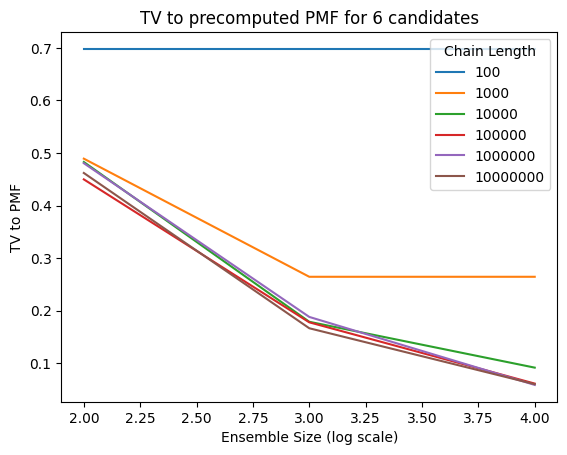

In [11]:
for i in range(len(num_ballots_arr)):
    plt.plot([math.log10(j) for j in size_of_ensembles], results_6_cands[i][::], label = f'{num_ballots_arr[i]}')
plt.xlabel('Ensemble Size (log scale)')
plt.ylabel(f'TV to PMF')
plt.title(f'TV to precomputed PMF for {n_cands} candidates')
legend = plt.legend()
legend.set_title('Chain Length')
plt.show()

The results are stable (at least from 5 to 6 candidates). Note that there is some tension between increasing the number of candidates and the need for more more sample sizes. 